In [1]:
# Project-IE590: Deep Learning for Machine Vision
# Keras Implementation of resnet50
# Kristiaan Hector | Varun Aggarwal | Aaron Etienn

In [1]:
# ensures back compatibility
from tensorflow.keras import backend as K

# for reading and preprocessing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD


# inceptionv4 model from keras with pretrained weights
from tensorflow.python.keras.applications.resnet import ResNet50, preprocess_input
import tensorflow as tf
# inception_resnet_v2.InceptionResNetV2

# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


In [2]:
DATASET_PATH  = './weed_data'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = 4
BATCH_SIZE    = 4
NUM_EPOCHS    = 25
WEIGHTS_FINAL = 'model-resnet_50-final_aanis.h5'

In [3]:
# specify data augmentation parameters for training images
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_batches = train_datagen.flow_from_directory(DATASET_PATH + '/train',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE)


valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(DATASET_PATH + '/val',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE)

Found 274 images belonging to 4 classes.
Found 93 images belonging to 4 classes.


In [4]:
# show class indices
print('****************')
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = cocklebur
Class #1 = foxtail
Class #2 = pigweed
Class #3 = ragweed
****************


In [5]:
# resnet50 - model setup
model = ResNet50(include_top=False,
                        weights='imagenet',
                        input_tensor=None,
                        input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))


In [6]:
# adding final FC layer at the end of model
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense( NUM_CLASSES,
                      activation='softmax',
                      name='softmax')(x)

model = Model(inputs=model.input,
              outputs=output_layer)


# ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

# setting up optimizer for model
# model.compile(optimizer=Adam(lr=1e-5),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [5]:
# load saved weights
model.load_weights(WEIGHTS_FINAL)

In [8]:
# train the model
hist = model.fit_generator(train_batches,
                    steps_per_epoch = train_batches.samples // BATCH_SIZE,
                    validation_data = valid_batches,
                    validation_steps = valid_batches.samples // BATCH_SIZE,
                    epochs = NUM_EPOCHS)

Epoch 1/25
68/68 [==============================] - 29s 434ms/step - loss: 3.0776 - accuracy: 0.5815 - val_loss: 0.7200 - val_accuracy: 0.8261
Epoch 2/25
68/68 [==============================] - 30s 442ms/step - loss: 2.4483 - accuracy: 0.7185 - val_loss: 1.0751 - val_accuracy: 0.9022
Epoch 3/25
68/68 [==============================] - 30s 442ms/step - loss: 2.4219 - accuracy: 0.7963 - val_loss: 1.2369 - val_accuracy: 0.9130
Epoch 4/25
68/68 [==============================] - 29s 425ms/step - loss: 1.9348 - accuracy: 0.8296 - val_loss: 1.4057 - val_accuracy: 0.8587
Epoch 5/25
68/68 [==============================] - 28s 416ms/step - loss: 1.6125 - accuracy: 0.8333 - val_loss: 1.3794 - val_accuracy: 0.8913
Epoch 6/25
68/68 [==============================] - 29s 422ms/step - loss: 1.7621 - accuracy: 0.8407 - val_loss: 0.9166 - val_accuracy: 0.9130
Epoch 7/25
68/68 [==============================] - 30s 437ms/step - loss: 1.4665 - accuracy: 0.8407 - val_loss: 0.3161 - val_accuracy: 0.9565

In [10]:
# save trained weights
model.save(WEIGHTS_FINAL)

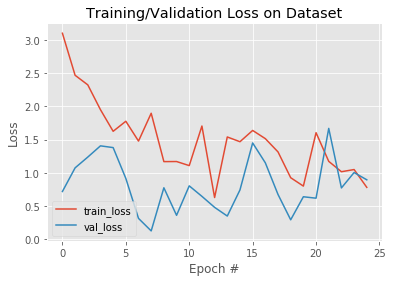

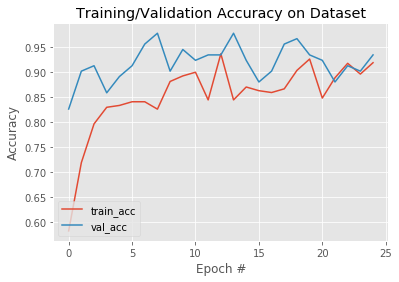

In [9]:
# Plot Results

N=NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), hist.history["val_loss"], label="val_loss")

plt.title("Training/Validation Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot_loss.png")

plt.figure()
plt.plot(np.arange(0, N), hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), hist.history["val_accuracy"], label="val_acc")

plt.title("Training/Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [10]:
# test model

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(DATASET_PATH + '/test',
                                                  target_size=IMAGE_SIZE,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=1)

out = model.evaluate_generator(test_batches, use_multiprocessing=True)
print(list(zip(model.metrics_names,out)))

Found 91 images belonging to 4 classes.
[('loss', 0.6843069700094601), ('accuracy', 0.93406594)]


In [13]:
test_batches.reset()

In [11]:
Y_pred = model.predict_generator(test_batches, use_multiprocessing=True)
# print(len(Y_pred))



 Classification Report

              precision    recall  f1-score   support

   cocklebur       0.62      0.83      0.71         6
     foxtail       0.93      0.93      0.93        14
     pigweed       0.97      1.00      0.99        35
     ragweed       0.97      0.89      0.93        36

    accuracy                           0.93        91
   macro avg       0.87      0.91      0.89        91
weighted avg       0.94      0.93      0.94        91



Confusion Matrix



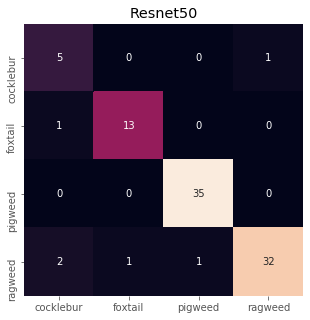

In [12]:
y_pred = np.argmax(Y_pred, axis=1)

print('\n\n Classification Report\n')
target_names = list(test_batches.class_indices.keys())
print(classification_report(list(test_batches.classes), y_pred, target_names=target_names))


print('\n\nConfusion Matrix\n')
cm = confusion_matrix(test_batches.classes, y_pred)

# row_sums = cm.sum(axis=1)
# cm = cm / row_sums

df_cm = pd.DataFrame(cm, index = ['cocklebur','foxtail','pigweed','ragweed'], columns = ['cocklebur','foxtail','pigweed','ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize = (5,5))
plt.title('Resnet50')
# sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
sn.heatmap(df_cm, annot=True, cbar=False)

plt.savefig('Resnet50.png')